In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.interpolate import interp1d
import lmfit as lm
import scipy.cluster.hierarchy as ch

In [12]:
egfp=np.array(pd.read_excel('20170316_K1_gfp_timecorr.xlsx', index_col=None,header=None)).T
time = np.array(egfp[0]/60/60)
egfp = egfp[1:]
print(egfp.shape)

(95, 73)


In [13]:
def twostage(t,t0,ktl,delta,beta,off=0):
    km=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    t0=np.abs(t0)
    return off+(ktl/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))).clip(0)
twostage_model = lm.Model(twostage)

In [14]:
def threestage(t,t0,ktl,km,delta,beta,off=0):
    km=np.abs(km)
    ktl=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    dmb = delta-beta
    bkm = beta + km
    dmbk = delta-bkm
    t0=np.abs(t0)
    dt=t-t0
    result = 1/dmb +km*np.exp(-dmb*dt)/dmb/dmbk-np.exp(-km*dt)/dmbk
    result = ktl*np.exp(-beta*dt)*result.clip(0)
    result[t<t0]=0
    return off+result
threestage_model = lm.Model(threestage)

[[Model]]
    Model(twostage)
[[Fit Statistics]]
    # function evals   = 89
    # data points      = 73
    # variables        = 5
    chi-square         = 14.033
    reduced chi-square = 0.206
    Akaike info crit   = -105.200
    Bayesian info crit = -93.748
[[Variables]]
    t0:      2.95421044 +/- 0.016788 (0.57%) (init= 4)
    ktl:     91.8761785 +/- 1.255303 (1.37%) (init= 800)
    delta:   0.01372252 +/- 0.300757 (2191.71%) (init= 0.07)
    beta:    0.01373413 +/- 0.300773 (2189.97%) (init= 0.05)
    off:     7.03565841 +/- 0.284013 (4.04%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(delta, beta)               = -1.000 
    C(t0, ktl)                   =  0.720 
    C(t0, off)                   =  0.184 

[[Model]]
    Model(threestage)
[[Fit Statistics]]
    # function evals   = 232
    # data points      = 73
    # variables        = 6
    chi-square         = 7.650
    reduced chi-square = 0.114
    Akaike info crit   = -146.407
    Bayesian info 

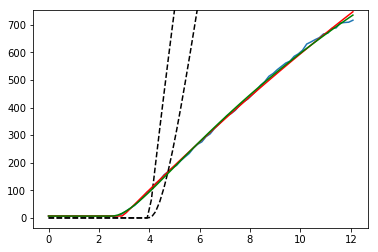

In [15]:
data = egfp[40]
sigma = np.sqrt(data)
result2 = twostage_model.fit(data, t=time, t0=4, ktl=800, delta=0.07, beta=0.05, weights=1/sigma)
result3 = threestage_model.fit(data, t=time, t0=4, ktl=800, km=1,delta=0.07, beta=0.05, weights=1/sigma)
plt.figure()
plt.plot(time,data)
plt.plot(time,result2.init_fit, 'k--')
plt.plot(time, result2.best_fit, 'r-')
plt.plot(time,result3.init_fit, 'k--')
plt.plot(time, result3.best_fit, 'g-')
plt.ylim((-0.05*data.max(),data.max()*1.05))
print(result2.fit_report())
print(result3.fit_report())

In [16]:
# cluster analysis to find the onset for fluorescence
# normalize the data
time_norm=(time-time.min())/50/(time.max()-time.min())
t0cluster_list=[]
for data in egfp:
    data_norm=(data-data.min())/(data.max()-data.min())
    data_diff_norm=np.gradient(data_norm)
    # combine the data
    X = np.vstack((time_norm,data_norm,data_diff_norm)).T
    # generate the linkage matrix
    Z = ch.linkage(X, method='single',metric='cityblock')
    tree = ch.cut_tree(Z, height=0.003).flatten()
    t0cluster_list.append(tree[tree==0].size)
t0cluster_list=np.array(t0cluster_list)
# convert to hours
t0cluster_list=(t0cluster_list)*10/60

data set 0 t0_guess 2.7473111510791366
data set 1 t0_guess 2.8305202876675843
data set 2 t0_guess 2.4044551346744716
data set 3 t0_guess 4.117206623470122
data set 4 t0_guess 4.713586060122373
data set 5 t0_guess 4.123281141822442
data set 6 t0_guess 6.062862813197718
data set 7 t0_guess 3.6306967984934087
data set 8 t0_guess 3.1599922320815033
data set 9 t0_guess 4.035297794445933
data set 10 t0_guess 2.7442832602706106
data set 11 t0_guess 2.734815818488556
data set 12 t0_guess 3.0378872044130696
data set 13 t0_guess 4.654940801457196
data set 14 t0_guess 3.2699696435932992
data set 15 t0_guess 2.908253546099291
data set 16 t0_guess 3.7801126516464474
data set 17 t0_guess 3.347480280455741
data set 18 t0_guess 3.8638694219826295
data set 19 t0_guess 5.785135708227311
data set 20 t0_guess 3.831340431340432
data set 21 t0_guess 4.11353957796238
data set 22 t0_guess 2.655693564521507


/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


data set 23 t0_guess 5.118866899495537
data set 24 t0_guess 2.9207040062232594
data set 25 t0_guess 2.7675186225969046
data set 26 t0_guess 3.2346662468513854
data set 27 t0_guess 4.164874290821482
data set 28 t0_guess 3.821860614066691
data set 29 t0_guess 2.590043586704203
data set 30 t0_guess 2.4990576781778104
data set 31 t0_guess 2.4852830002334394
data set 32 t0_guess 6.439014117013501
data set 33 t0_guess 5.442339667458432
data set 34 t0_guess 4.5335746606334855
data set 35 t0_guess 3.1055364455364454
data set 36 t0_guess 3.2580645161290325
data set 37 t0_guess 2.3637754309675416
data set 38 t0_guess 3.674192024575436
data set 39 t0_guess 3.502841753343239
data set 40 t0_guess 3.676842005497109
data set 41 t0_guess 2.5316053192270958
data set 42 t0_guess 2.7375691609977326
data set 43 t0_guess 2.622492759765487
data set 44 t0_guess 2.667321654040404
data set 45 t0_guess 2.579592827365656
data set 46 t0_guess 2.911691542288557
data set 47 t0_guess 4.324156329198346
data set 48 t0

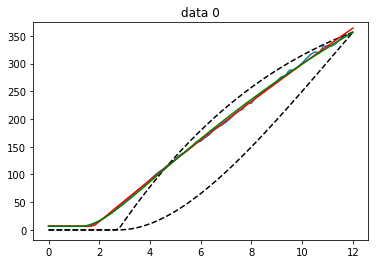

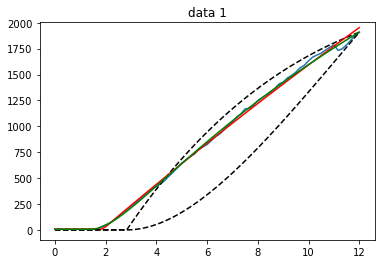

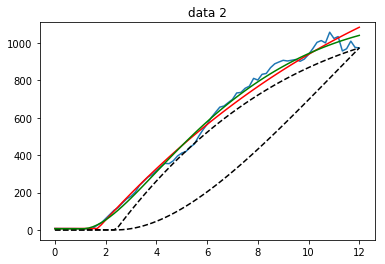

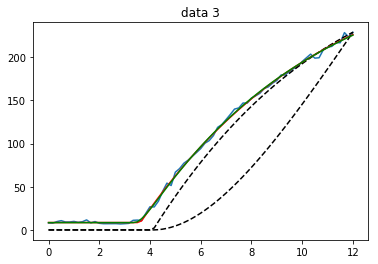

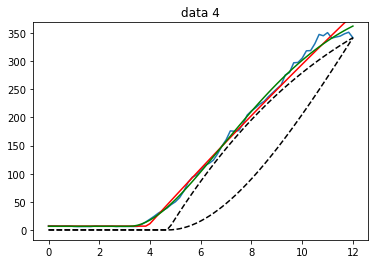

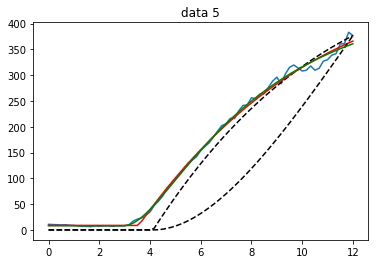

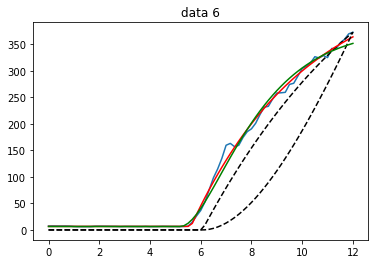

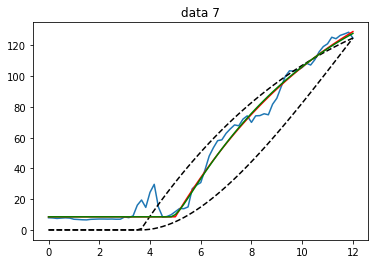

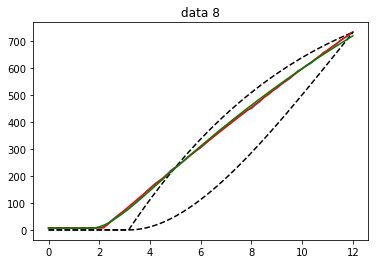

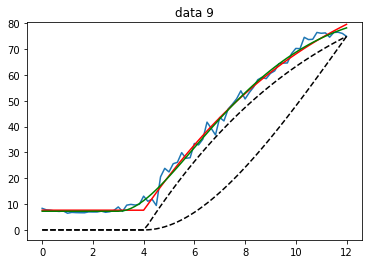

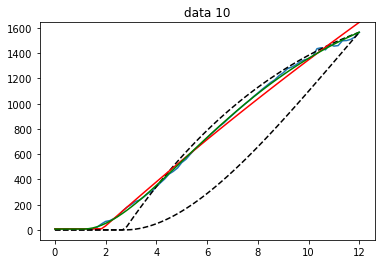

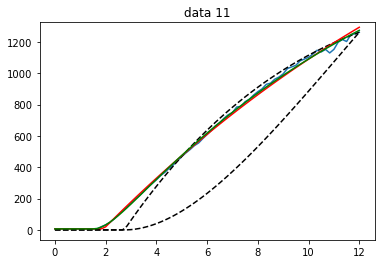

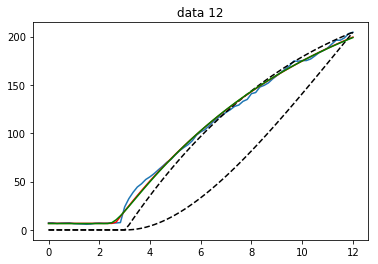

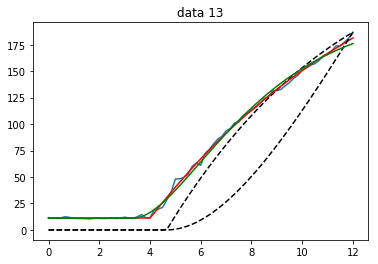

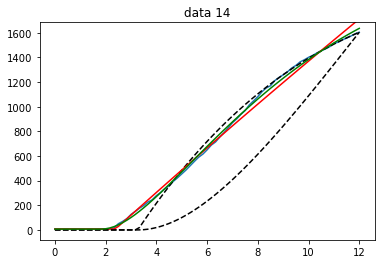

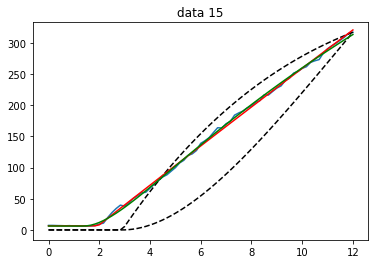

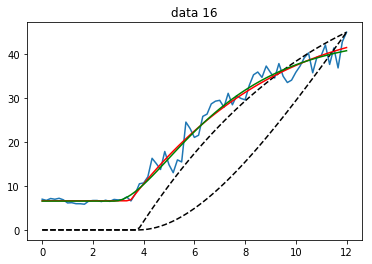

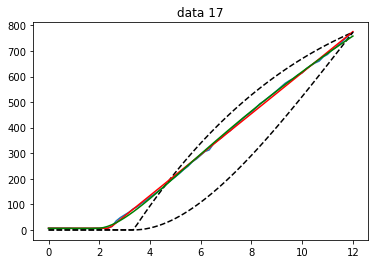

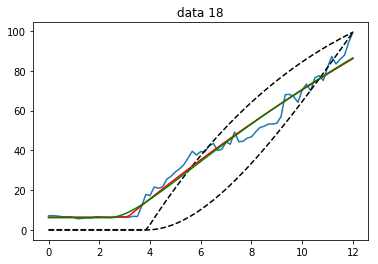

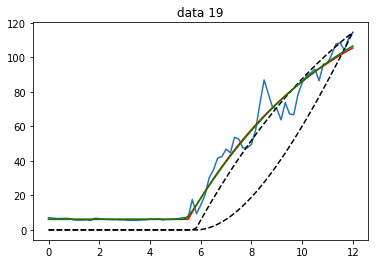

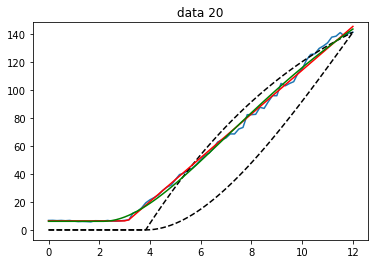

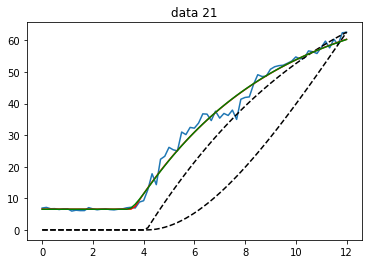

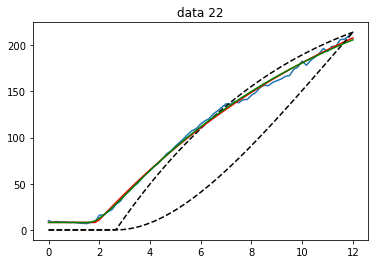

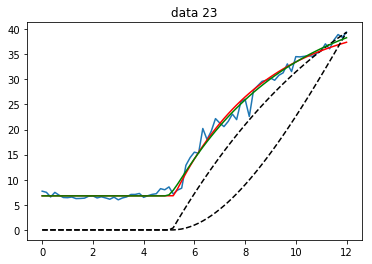

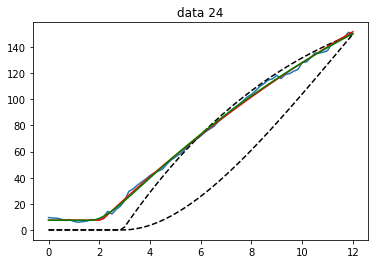

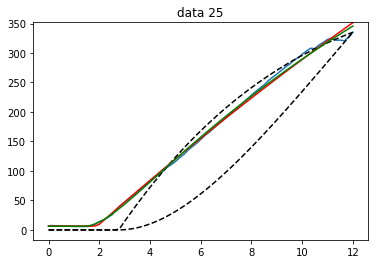

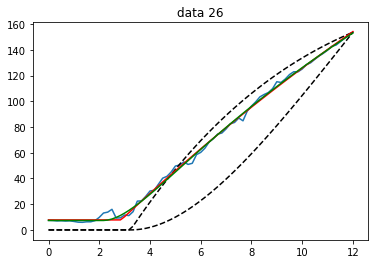

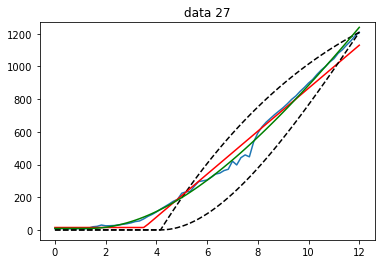

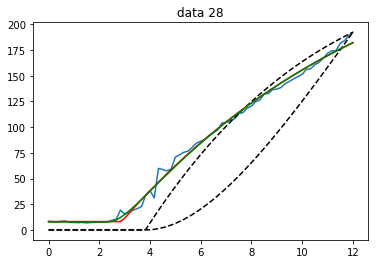

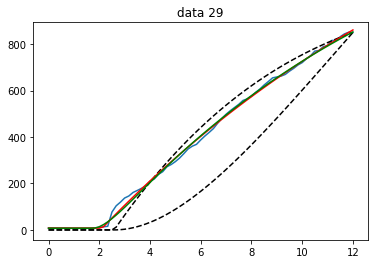

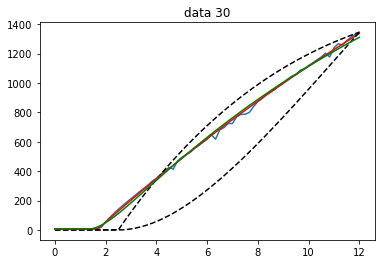

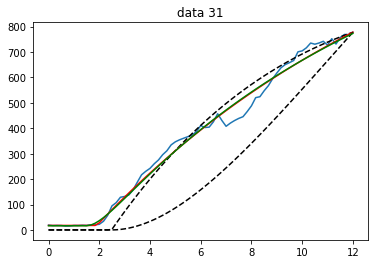

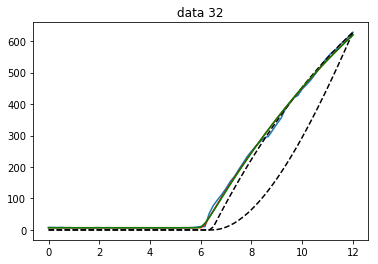

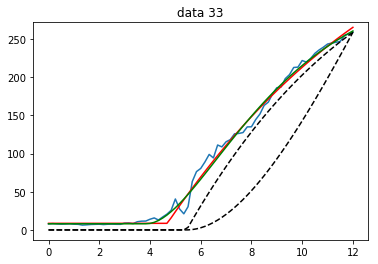

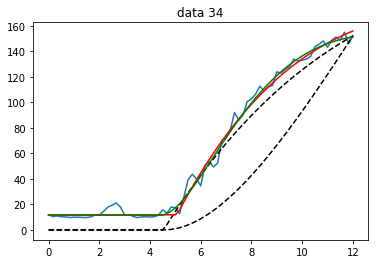

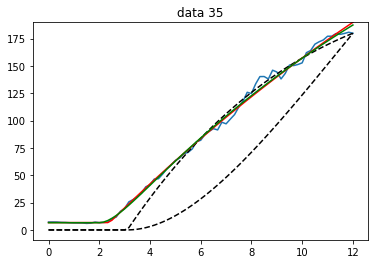

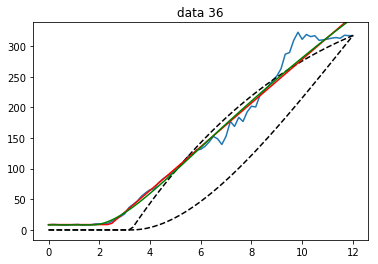

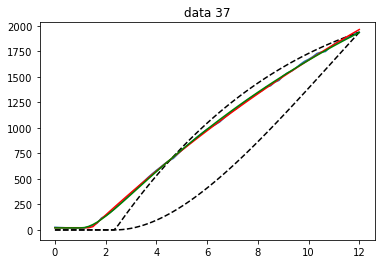

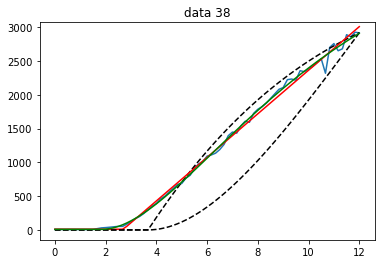

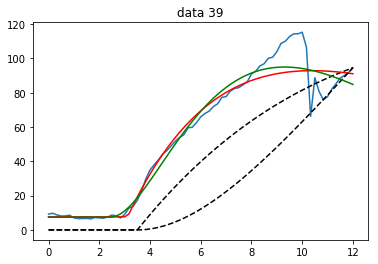

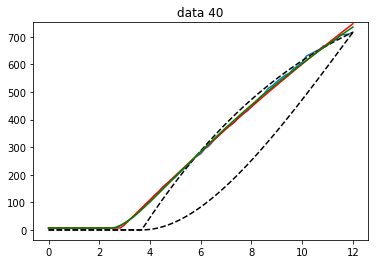

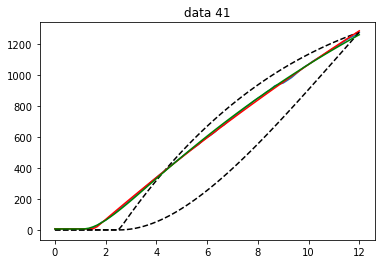

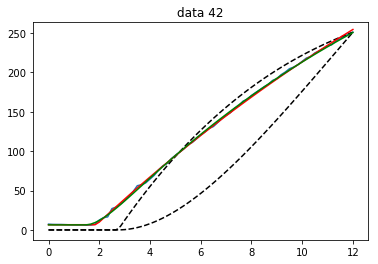

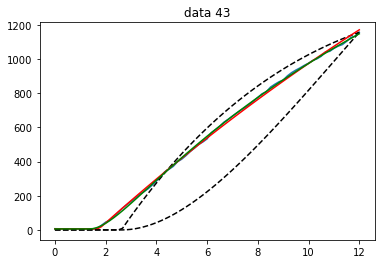

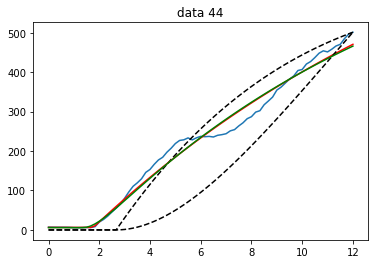

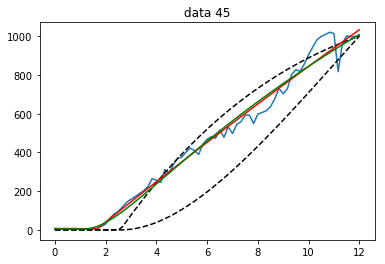

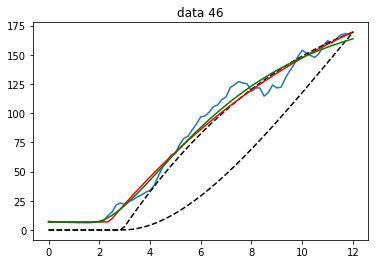

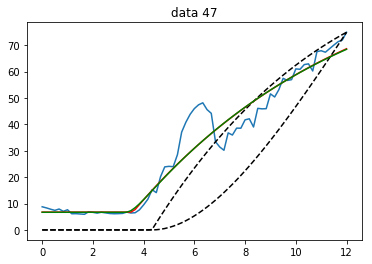

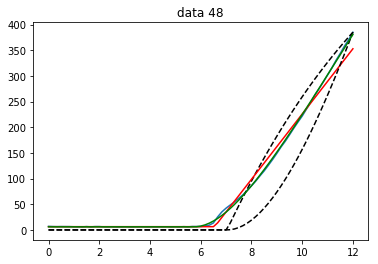

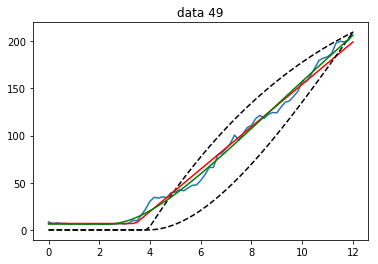

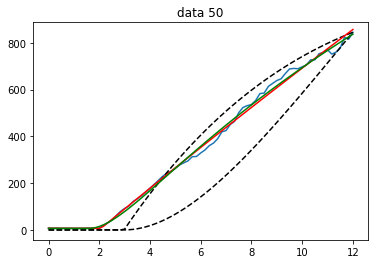

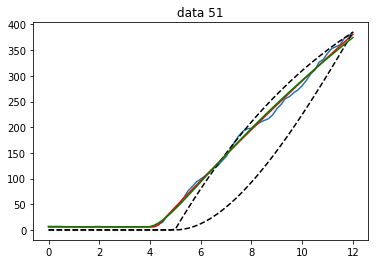

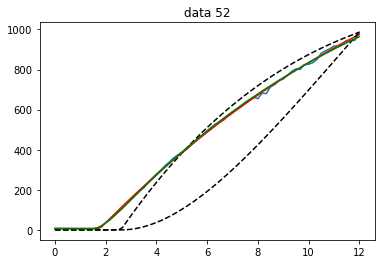

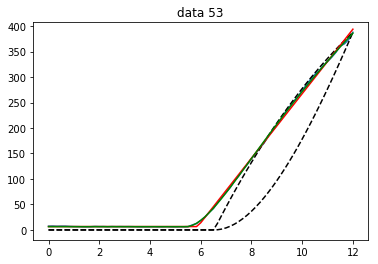

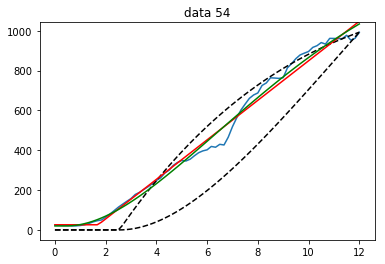

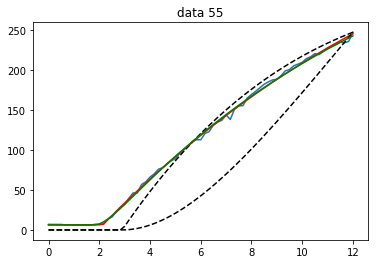

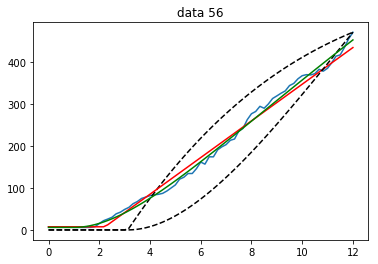

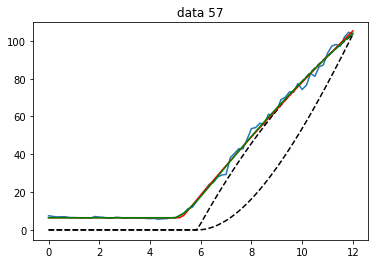

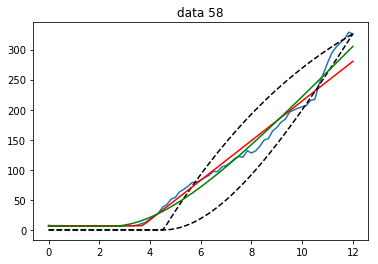

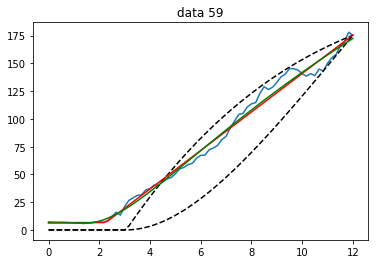

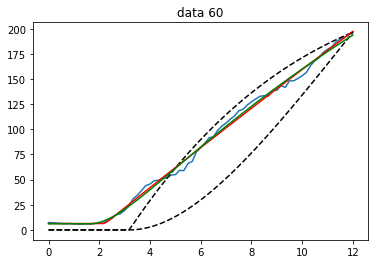

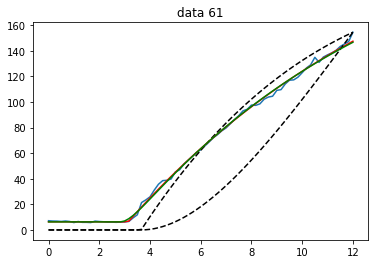

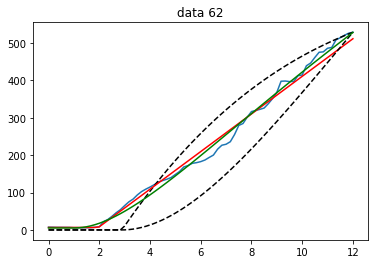

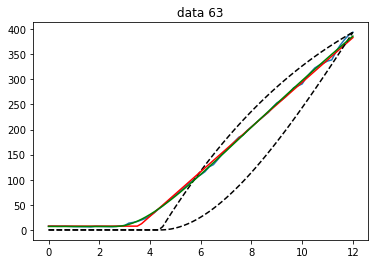

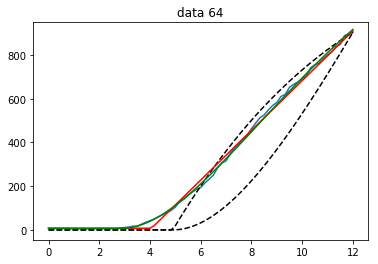

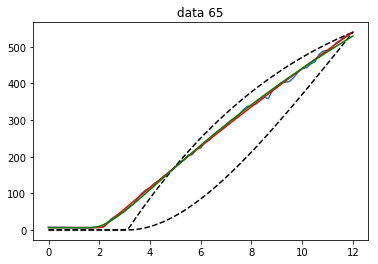

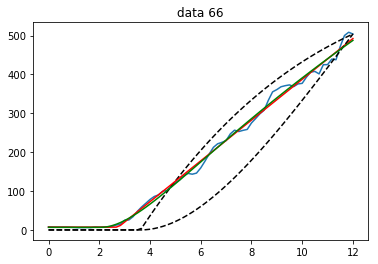

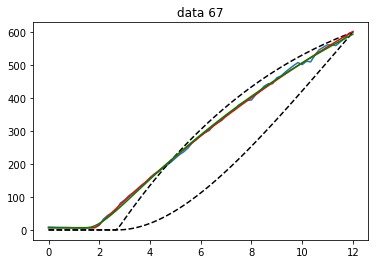

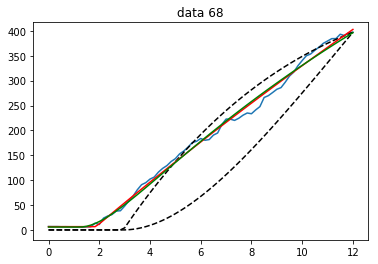

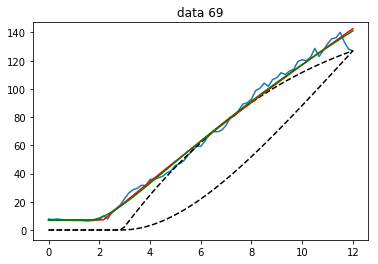

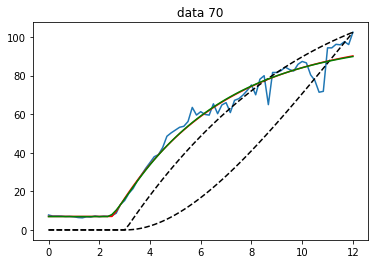

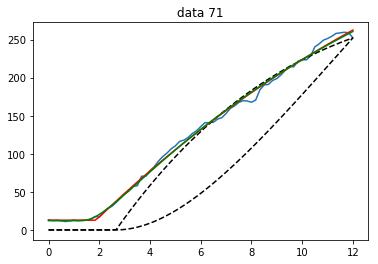

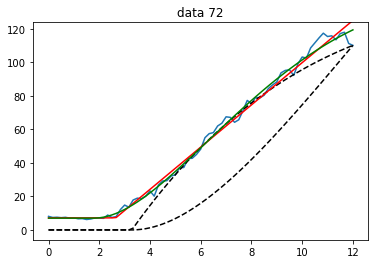

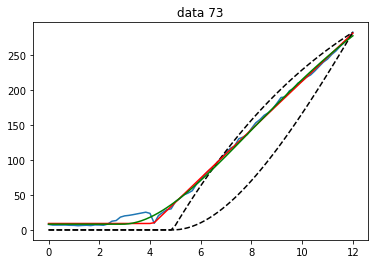

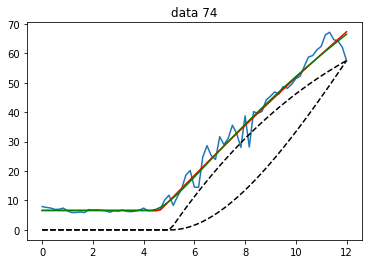

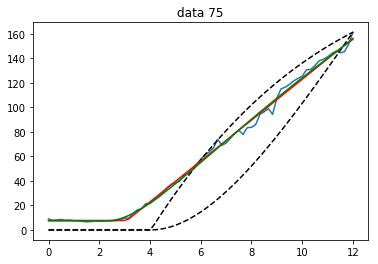

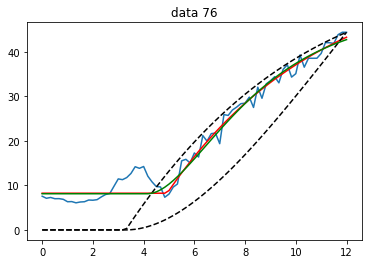

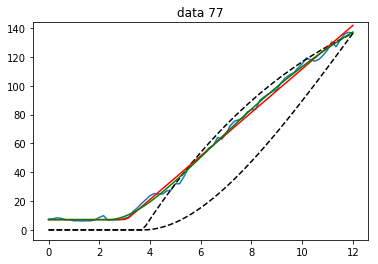

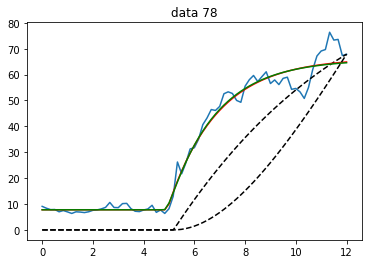

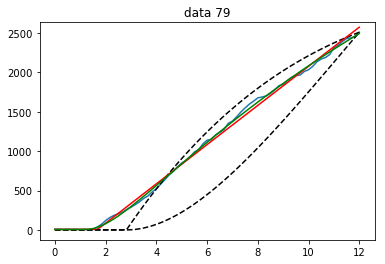

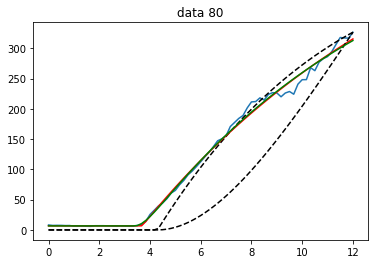

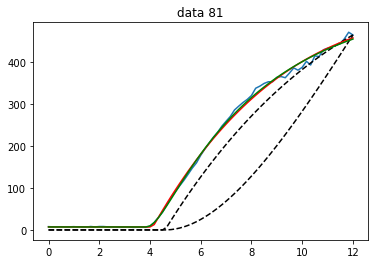

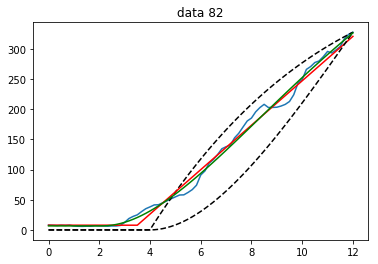

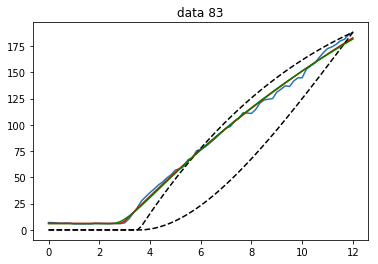

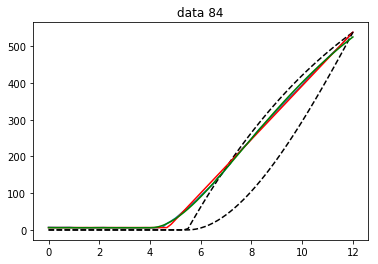

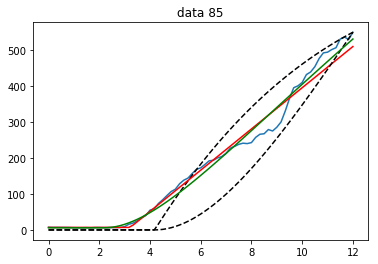

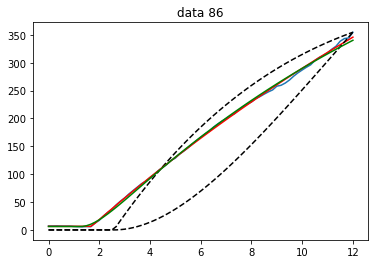

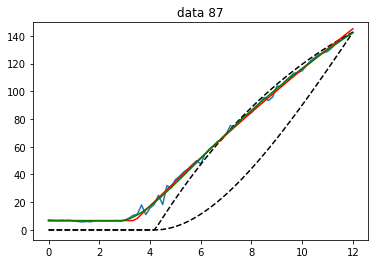

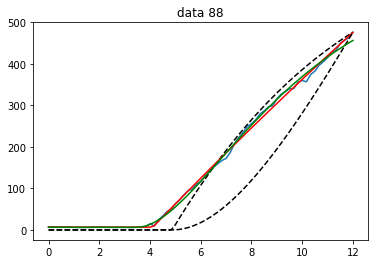

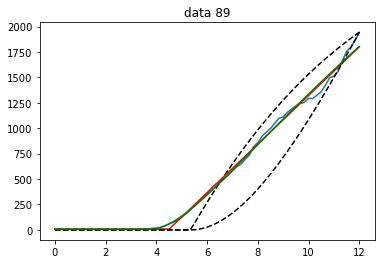

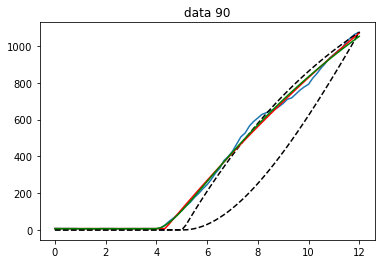

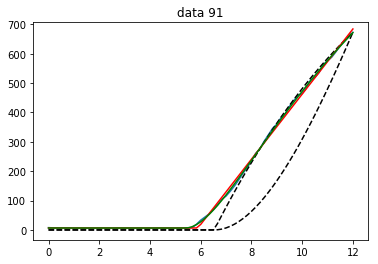

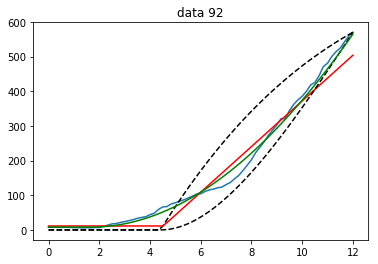

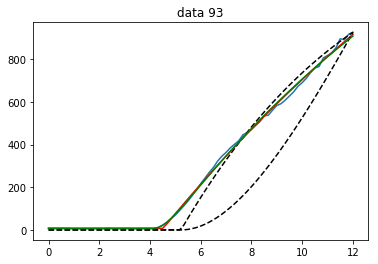

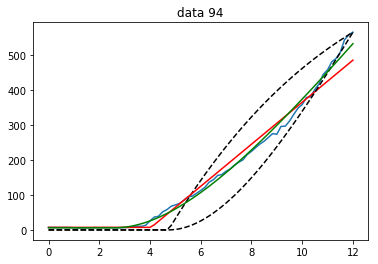

In [17]:
# two stage model
t0_list=[]
ktl_list=[]
delta_list=[]
beta_list=[]
t0_std_list=[]
ktl_std_list=[]
delta_std_list=[]
beta_std_list=[]
red_chi2_list=[]

# three stage model
t0_list3=[]
ktl_list3=[]
km_list3=[]
delta_list3=[]
beta_list3=[]
t0_std_list3=[]
ktl_std_list3=[]
km_std_list3=[]
delta_std_list3=[]
beta_std_list3=[]
red_chi2_list3=[]

for data,i in zip(egfp,range(t0cluster_list.size)):
    sigma = np.sqrt(data)
    time = np.arange(0,data.size)*10/60
    # lets estimate the parameters
    # to estimate t0 we take I_max-I_min and estimate t for which I=I_min+0.1(I_max-Imin)
    # this can be done by interpolation.  The advantage is that the guess for t0 is greater
    # than the actual value - fits seems to converge better
    delta_I=data.max()-data.min()
    t0guess = interp1d(data,time)(data.min()+0.1*delta_I)
    print("data set",i,"t0_guess",t0guess)
    delta_t=time[-1]-t0guess
    
    two=twostage(np.array([delta_t]),0,1,0.07,0.05)
    ktl2=data[-1]/two[0]
    
    three=threestage(np.array([delta_t]),0,1,0.03,0.07,0.05)
    ktl3=data[-1]/three[0]
    
    result2 = twostage_model.fit(data, t=time, t0=t0guess, ktl=ktl2, delta=0.07, beta=0.05, weights=1/sigma)
    result3 = threestage_model.fit(data, t=time, t0=t0guess, ktl=ktl3, km=0.03,delta=0.07, beta=0.05, weights=1/sigma)

    plt.figure()
    plt.title("data "+str(i))
    plt.plot(time,data)
    plt.plot(time,result2.init_fit, 'k--')
    plt.plot(time, result2.best_fit, 'r-')
    plt.plot(time,result3.init_fit, 'k--')
    plt.plot(time, result3.best_fit, 'g-')
    plt.ylim((-0.05*data.max(),data.max()*1.05))
    
    if result2:
        t0_list.append(np.abs(result2.values['t0']))
        ktl_list.append(np.abs(result2.values['ktl']))
        delta_list.append(np.abs(result2.values['delta']))
        beta_list.append(np.abs(result2.values['beta']))
        red_chi2_list.append(result2.redchi)

        t0_std_list.append(result2.covar[0][0])
        ktl_std_list.append(result2.covar[1][1])
        delta_std_list.append(result2.covar[2][2])
        beta_std_list.append(result2.covar[3][3])
    
    if result3:
        t0_list3.append(np.abs(result3.values['t0']))
        ktl_list3.append(np.abs(result3.values['ktl']))
        km_list3.append(np.abs(result3.values['km']))
        delta_list3.append(np.abs(result3.values['delta']))
        beta_list3.append(np.abs(result3.values['beta']))
        red_chi2_list3.append(result3.redchi)

        t0_std_list3.append(result3.covar[0][0])
        ktl_std_list3.append(result3.covar[1][1])
        km_std_list3.append(result3.covar[2][2])
        delta_std_list3.append(result3.covar[3][3])
        beta_std_list3.append(result3.covar[4][4])
    
t0_list=np.array(t0_list)
ktl_list=np.array(ktl_list)
delta_list=np.array(delta_list)
beta_list=np.array(beta_list)
t0_std_list=np.array(t0_std_list)
ktl_std_list=np.array(ktl_std_list)
delta_std_list=np.array(delta_std_list)
beta_std_list=np.array(beta_std_list)

t0_list3=np.array(t0_list3)
ktl_list3=np.array(ktl_list3)
km_list3=np.array(km_list3)
delta_list3=np.array(delta_list3)
beta_list3=np.array(beta_list3)
t0_std_list3=np.array(t0_std_list3)
ktl_std_list3=np.array(ktl_std_list3)
km_std_list3=np.array(km_std_list3)
delta_std_list3=np.array(delta_std_list3)
beta_std_list3=np.array(beta_std_list3)

red_chi2_list=np.array(red_chi2_list)
red_chi2_list3=np.array(red_chi2_list3)


0.804810674474 0.558394542081
1.26392339972 0.649755491148
[ 3.8864596   2.62601664  0.91231927  0.32169133  0.15224444  0.05572929]
[ 2.09701399  1.99386565  0.72400689  0.29972158  0.14669931  0.05828538]


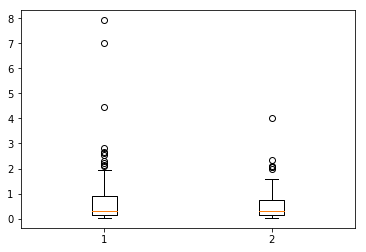

In [18]:
plt.boxplot([red_chi2_list,red_chi2_list3])
print(red_chi2_list.mean(),red_chi2_list3.mean())
print(red_chi2_list.std(),red_chi2_list3.std())
print(np.percentile(red_chi2_list,[97.5,95,75,50,25,2.5]))
print(np.percentile(red_chi2_list3,[97.5,95,75,50,25,2.5]))

In [19]:
print(np.argmax(red_chi2_list),red_chi2_list.max())
print(np.argmax(red_chi2_list3),red_chi2_list3.max())

92 7.91728808614
45 4.02020707541


In [20]:
# cleaning up the data by setting a threshold for redchi2
threshold2 = 150
threshold3 = 150
ktl_list_clean=ktl_list[red_chi2_list<threshold2]
delta_list_clean=delta_list[red_chi2_list<threshold2]
beta_list_clean=beta_list[red_chi2_list<threshold2]
t0_list_clean=t0_list[red_chi2_list<threshold2]
ktl_std_list_clean=ktl_std_list[red_chi2_list<threshold2]
delta_std_list_clean=delta_std_list[red_chi2_list<threshold2]
beta_std_list_clean=beta_std_list[red_chi2_list<threshold2]
t0_std_list_clean=t0_std_list[red_chi2_list<threshold2]

ktl_list3_clean=ktl_list3[red_chi2_list3<threshold3]
km_list3_clean=km_list3[red_chi2_list3<threshold3]
delta_list3_clean=delta_list3[red_chi2_list3<threshold3]
beta_list3_clean=beta_list3[red_chi2_list3<threshold3]
t0_list3_clean=t0_list3[red_chi2_list3<threshold3]
km_std_list3_clean=km_std_list3[red_chi2_list3<threshold3]
ktl_std_list3_clean=ktl_std_list3[red_chi2_list3<threshold3]
delta_std_list3_clean=delta_std_list3[red_chi2_list3<threshold3]
beta_std_list3_clean=beta_std_list3[red_chi2_list3<threshold3]
t0_std_list3_clean=t0_std_list3[red_chi2_list3<threshold3]


In [21]:
print(ktl_list.size,ktl_list_clean.size)
print(ktl_list3.size,ktl_list3_clean.size)

95 95
95 95


68.6783346624 4551.73679958


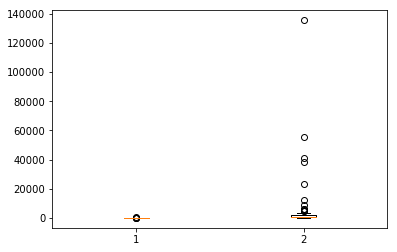

In [22]:
plt.boxplot([ktl_list_clean,ktl_list3_clean])
print(ktl_list_clean.mean(),ktl_list3_clean.mean())

(array([ 90.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.43002572e+01,   1.35771044e+04,   2.71299086e+04,
          4.06827127e+04,   5.42355169e+04,   6.77883211e+04,
          8.13411252e+04,   9.48939294e+04,   1.08446734e+05,
          1.21999538e+05,   1.35552342e+05]),
 <a list of 10 Patch objects>)

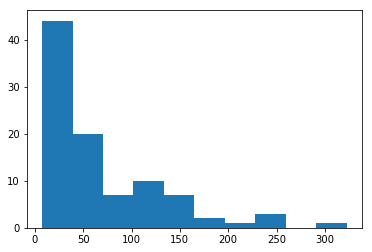

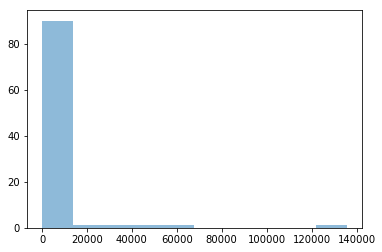

In [23]:
plt.figure()
plt.hist(ktl_list_clean)
plt.figure()
plt.hist(ktl_list3_clean,alpha=0.5)

(array([ 45.,  34.,   4.,   4.,   4.,   1.,   2.,   0.,   0.,   1.]),
 array([ 0.00213246,  0.05589779,  0.10966312,  0.16342846,  0.21719379,
         0.27095912,  0.32472446,  0.37848979,  0.43225512,  0.48602045,
         0.53978579]),
 <a list of 10 Patch objects>)

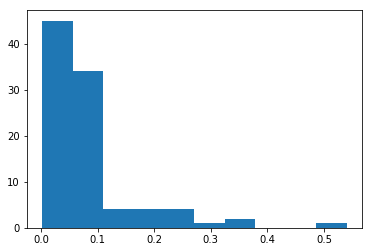

In [24]:
plt.figure()
plt.hist(km_list3_clean)

{'boxes': [<matplotlib.lines.Line2D at 0x113a35160>,
 'caps': [<matplotlib.lines.Line2D at 0x1172b78d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x11a0bce48>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11a0bc438>,
 'whiskers': [<matplotlib.lines.Line2D at 0x113631cf8>,
  <matplotlib.lines.Line2D at 0x11b445b00>]}

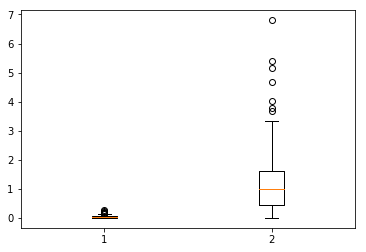

In [25]:
plt.boxplot([delta_list_clean,delta_list3_clean])

0.0403742598273 1.30531824399


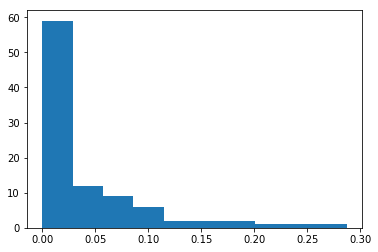

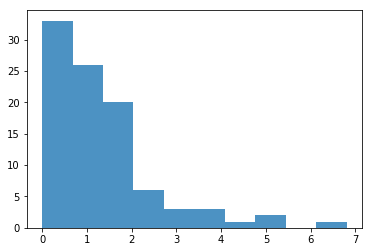

In [26]:
plt.figure()
plt.hist(delta_list_clean)
plt.figure()
plt.hist(delta_list3_clean,alpha=0.8)
print(delta_list_clean.mean(),delta_list3_clean.mean())

{'boxes': [<matplotlib.lines.Line2D at 0x10f72d630>,
 'caps': [<matplotlib.lines.Line2D at 0x10f703f98>,
 'fliers': [<matplotlib.lines.Line2D at 0x10f71c940>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10f718a20>,
 'whiskers': [<matplotlib.lines.Line2D at 0x10f72def0>,
  <matplotlib.lines.Line2D at 0x10f717b00>]}

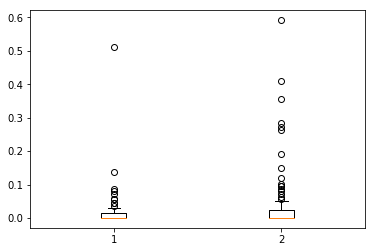

In [27]:
plt.boxplot([beta_list_clean,beta_list3_clean])

(array([ 79.,   7.,   2.,   1.,   3.,   0.,   2.,   0.,   0.,   1.]),
 array([  5.68111675e-09,   5.91656383e-02,   1.18331271e-01,
          1.77496904e-01,   2.36662536e-01,   2.95828169e-01,
          3.54993802e-01,   4.14159434e-01,   4.73325067e-01,
          5.32490700e-01,   5.91656332e-01]),
 <a list of 10 Patch objects>)

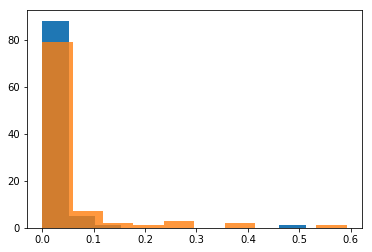

In [28]:
plt.hist(beta_list_clean)
plt.hist(beta_list3_clean,alpha=0.8)

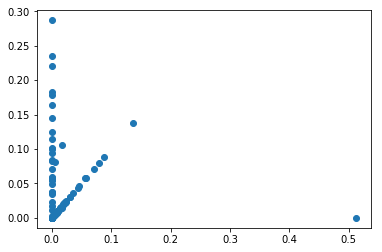

In [29]:
plt.plot(beta_list_clean,delta_list_clean,"o")

{'boxes': [<matplotlib.lines.Line2D at 0x116f2ab00>],
 'caps': [<matplotlib.lines.Line2D at 0x116f25748>,
 'fliers': [<matplotlib.lines.Line2D at 0x116f12e10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x116f37f28>],
 'whiskers': [<matplotlib.lines.Line2D at 0x116f2ad68>,
  <matplotlib.lines.Line2D at 0x116f25f60>]}

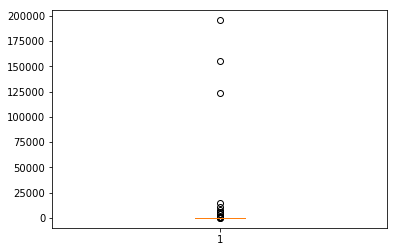

In [30]:
error_delta = delta_std_list_clean/delta_list_clean
plt.boxplot(error_delta)

{'boxes': [<matplotlib.lines.Line2D at 0x113a9d2e8>,
 'caps': [<matplotlib.lines.Line2D at 0x113a9ed30>,
 'fliers': [<matplotlib.lines.Line2D at 0x11b0b9f28>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11b0b9710>,
 'whiskers': [<matplotlib.lines.Line2D at 0x113a9dcc0>,
  <matplotlib.lines.Line2D at 0x11b0887b8>]}

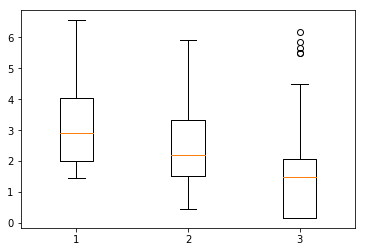

In [31]:
plt.boxplot([t0_list_clean,t0_list3_clean,t0cluster_list])

3.16390813463
2.53781079388
1.6


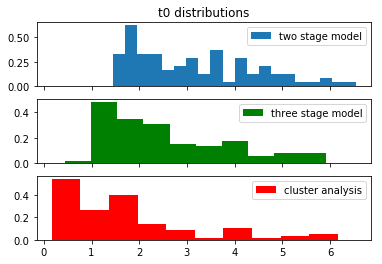

In [32]:
plt.figure()
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(3, sharex=True)
axarr[0].hist(t0_list_clean, bins=20,normed=True,label='two stage model')
axarr[0].set_title('t0 distributions')
axarr[0].legend()
axarr[1].hist(t0_list3_clean,bins=10,color='g',normed=True,label='three stage model')
axarr[1].legend()
axarr[2].hist(t0cluster_list,bins=10,color='r',normed=True,label='cluster analysis')
axarr[2].legend()
print(t0_list_clean.mean())
print(t0_list3_clean.mean())
print(t0cluster_list.mean())

In [33]:
# save data
np.save("k1_t0_two",t0_list_clean)
np.save("k1_t0_three",t0_list3_clean)
np.save("k1_t0_cluster",t0cluster_list)

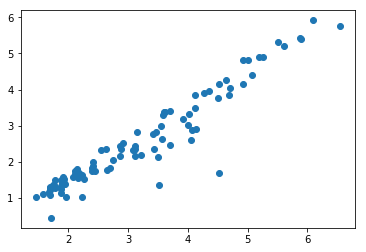

In [34]:
plt.plot(t0_list_clean,t0_list3_clean,"o")